# Dysarthric Speech Recognition Pipeline
## Comparative Study of Models (HMM, Bayesian GMM, Random Forest)

This notebook implements a pipeline for Dysarthric Speech Recognition using TORGO and RAWDysPeech datasets.
**Features:**
- **Fast Execution**: Uses Parallel Processing for feature extraction.
- **Comprehensive Visualization**: Feature distributions, Spectrograms, PCA, ROC Curves, Decision Trees.
- **Formal Hypothesis Testing**: Detailed statistical validation of feature differences.
- **Full Dataset Processing**: Uses 100% of the available data.

## 1. Setup and Imports

In [50]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.mixture import BayesianGaussianMixture
from hmmlearn import hmm
from scipy import stats
from joblib import Parallel, delayed
import time
import warnings

warnings.filterwarnings('ignore')

# Set random seed and plot style
np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Optimized Feature Extraction Functions

In [51]:
def get_file_paths(base_path, categories):
    """
    Get list of file paths and labels.
    """
    file_paths = []
    labels = []
    
    for category, label in categories.items():
        path = os.path.join(base_path, category)
        files = glob.glob(os.path.join(path, "**/*.wav"), recursive=True)
        file_paths.extend(files)
        labels.extend([label] * len(files))
        
    return np.array(file_paths), np.array(labels)

def process_single_file(file_path):
    """
    Process a single audio file: Load -> Extract Features.
    Returns feature vector or None if failed.
    """
    try:
        # Load with lower sample rate for speed (16kHz is standard for speech)
        y, sr = librosa.load(file_path, sr=16000)
        
        # Skip very short files
        if len(y) < 1024:
            return None

        # 1. MFCCs (13 coefficients)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        
        # 2. Pitch (F0) - Using YIN which is faster than pYIN
        f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        f0_mean = np.mean(f0)
        
        # 3. Formants (LPC)
        # Limit order for speed
        a = librosa.lpc(y, order=2 + sr // 1000)
        roots = np.roots(a)
        roots = [r for r in roots if np.imag(r) >= 0]
        angz = np.arctan2(np.imag(roots), np.real(roots))
        frqs = sorted(angz * (sr / (2 * np.pi)))
        formants = frqs[:3]
        while len(formants) < 3:
            formants.append(0)
            
        return np.concatenate([mfcc_mean, [f0_mean], formants])
    except Exception as e:
        return None

def extract_features_parallel(file_paths, n_jobs=-1):
    """
    Extract features in parallel.
    """
    print(f"Extracting features from {len(file_paths)} files using {n_jobs} jobs...")
    start_time = time.time()
    
    results = Parallel(n_jobs=n_jobs)(delayed(process_single_file)(fp) for fp in file_paths)
    
    # Filter out None results
    features = []
    valid_indices = []
    for i, res in enumerate(results):
        if res is not None:
            features.append(res)
            valid_indices.append(i)
            
    print(f"Finished in {time.time() - start_time:.2f} seconds.")
    return np.array(features), valid_indices

## 3. Visualization & Analysis Functions

In [52]:
def plot_waveform_spectrogram(file_path, title="Audio Sample"):
    y, sr = librosa.load(file_path, sr=16000)
    plt.figure(figsize=(14, 6))
    
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'{title} - Waveform')
    
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{title} - Spectrogram')
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(features, labels, feature_names):
    df = pd.DataFrame(features, columns=feature_names)
    df['Label'] = labels
    df['Label'] = df['Label'].map({0: 'Control', 1: 'Dysarthric'})
    
    # Plot first few MFCCs and F0
    cols_to_plot = feature_names[:4] + ['F0']
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(cols_to_plot):
        plt.subplot(2, 3, i+1)
        sns.boxplot(x='Label', y=col, data=df)
        plt.title(f'{col} Distribution')
    plt.tight_layout()
    plt.show()
    
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.drop('Label', axis=1).corr(), cmap='coolwarm', center=0)
    plt.title("Feature Correlation Matrix")
    plt.show()

def perform_formal_hypothesis_testing(features, labels, feature_index=0, feature_name="Feature"):
    """
    Performs a formal hypothesis test (T-test) with detailed output.
    """
    group0 = features[labels == 0, feature_index] # Control
    group1 = features[labels == 1, feature_index] # Dysarthric
    
    alpha = 0.05
    
    print(f"--- Hypothesis Testing for {feature_name} ---")
    print("1. State the Hypotheses:")
    print(f"   Null Hypothesis (H0): There is no significant difference in the mean {feature_name} between Control and Dysarthric speakers.")
    print(f"   Alternative Hypothesis (H1): There is a significant difference in the mean {feature_name} between Control and Dysarthric speakers.")
    
    print(f"\n2. Set the Significance Level (α):")
    print(f"   α = {alpha}")
    
    print("\n3. Collect Data:")
    print(f"   Control samples: {len(group0)}")
    print(f"   Dysarthric samples: {len(group1)}")
    print(f"   Mean (Control): {np.mean(group0):.4f}")
    print(f"   Mean (Dysarthric): {np.mean(group1):.4f}")
    
    # Perform T-test
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False) # Welch's t-test
    
    print("\n4. Perform the Statistical Test:")
    print(f"   Test Statistic (t): {t_stat:.4f}")
    print(f"   p-value: {p_val:.4e}")
    
    print("\n5. Interpret the Results:")
    if p_val < alpha:
        print(f"   Since p-value ({p_val:.4e}) < α ({alpha}), we REJECT the Null Hypothesis.")
        print(f"   Conclusion: There is statistically significant evidence to suggest a difference in {feature_name} between the two groups.")
    else:
        print(f"   Since p-value ({p_val:.4e}) >= α ({alpha}), we FAIL TO REJECT the Null Hypothesis.")
        print(f"   Conclusion: There is not enough evidence to suggest a significant difference in {feature_name} between the two groups.")
    print("-" * 60 + "\n")

## 4. TORGO Dataset Pipeline

In [53]:
TORGO_PATH = r"C:\Users\91959\Documents\BTech Studies\7th Semester Studies\Pattern Recognition_PE_05\PR Project\TORGO dataset"

print("Processing TORGO dataset...")
torgo_categories = {'F_Con': 0, 'M_Con': 0, 'F_Dys': 1, 'M_Dys': 1}
torgo_files, torgo_labels_all = get_file_paths(TORGO_PATH, torgo_categories)

# Subsample (100% - Full Dataset)
sample_rate = 1.0
if sample_rate < 1.0:
    indices = np.random.choice(len(torgo_files), int(len(torgo_files) * sample_rate), replace=False)
    torgo_files = torgo_files[indices]
    torgo_labels_all = torgo_labels_all[indices]

# Extract Features
torgo_features, valid_idx = extract_features_parallel(torgo_files)
torgo_labels = torgo_labels_all[valid_idx]
print(f"TORGO features shape: {torgo_features.shape}")

# Feature Names (13 MFCCs + F0 + 3 Formants)
feat_names = [f'MFCC_{i+1}' for i in range(13)] + ['F0', 'F1', 'F2', 'F3']

Processing TORGO dataset...
Extracting features from 17633 files using -1 jobs...
Finished in 115.55 seconds.
TORGO features shape: (17599, 17)


### 4.1 Exploratory Data Analysis (TORGO)

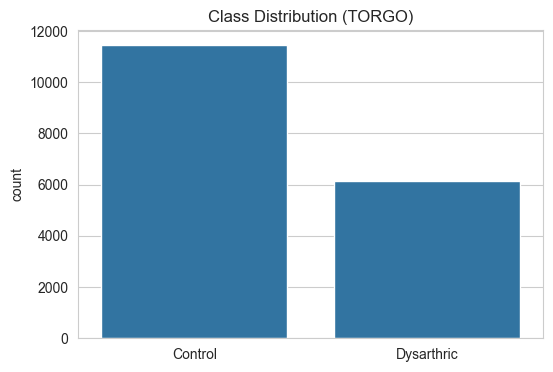

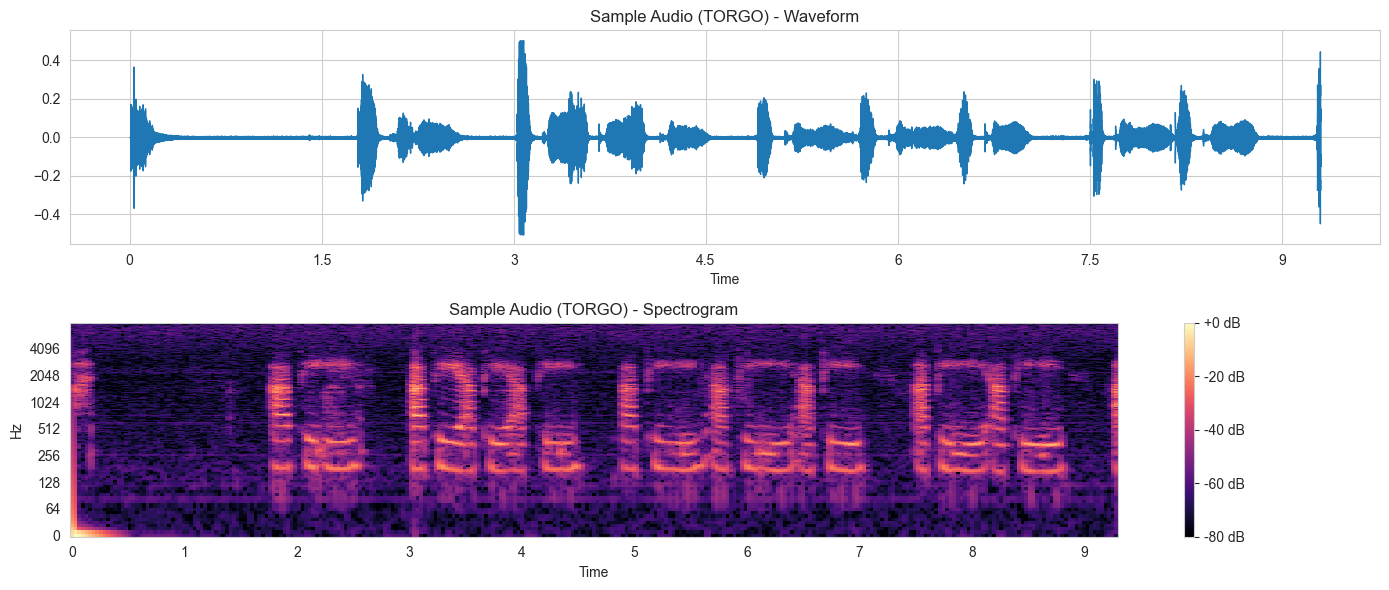

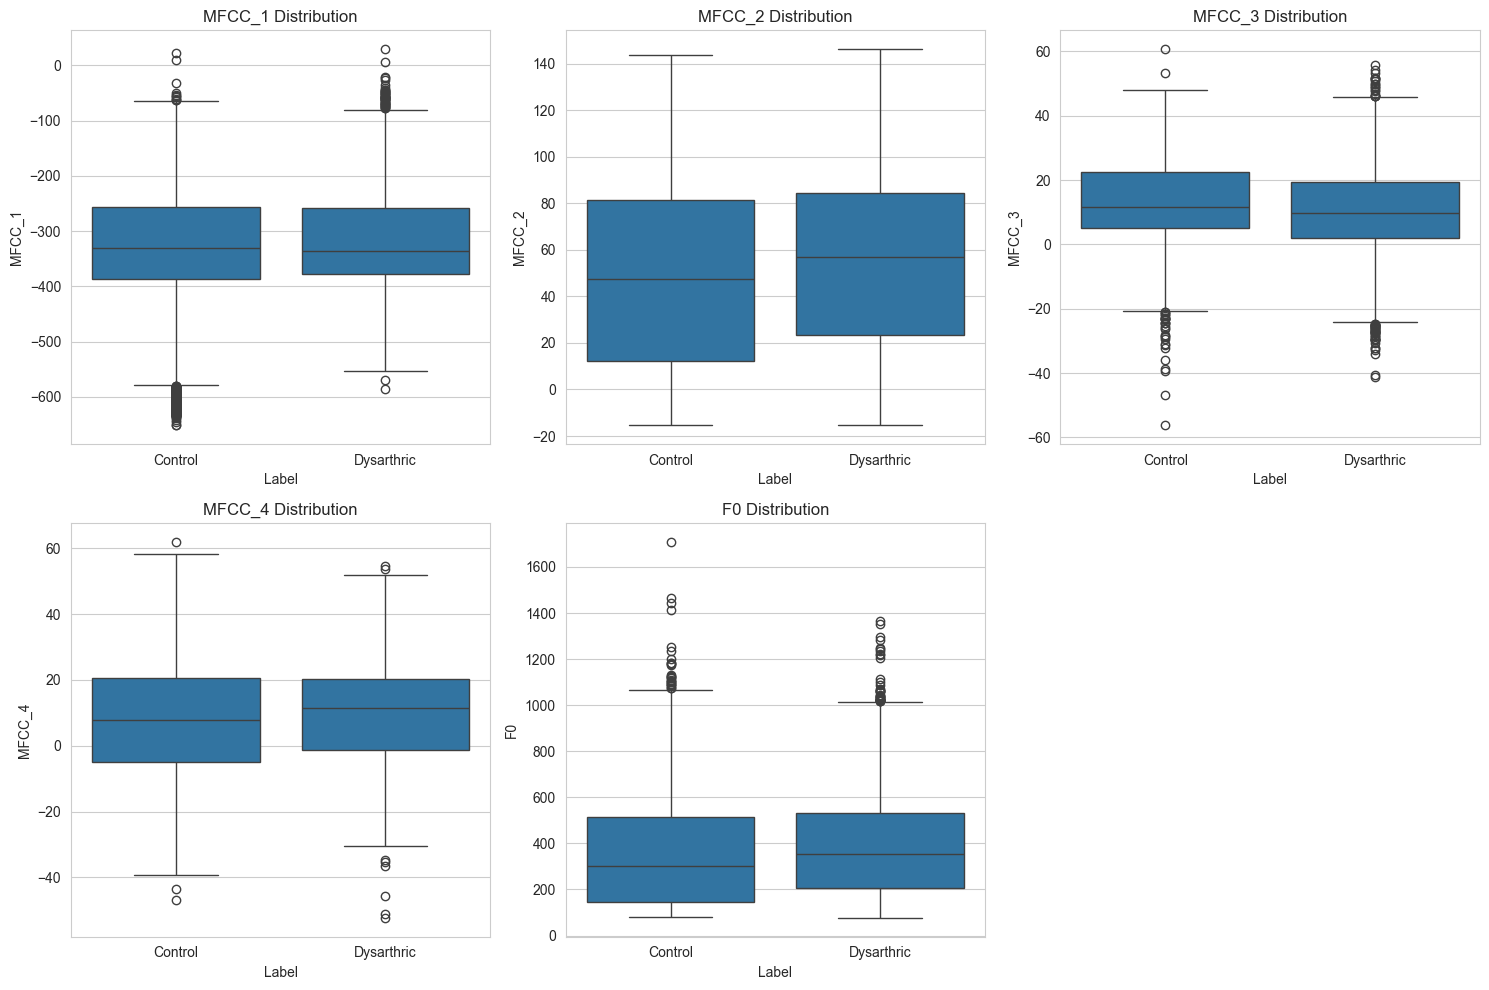

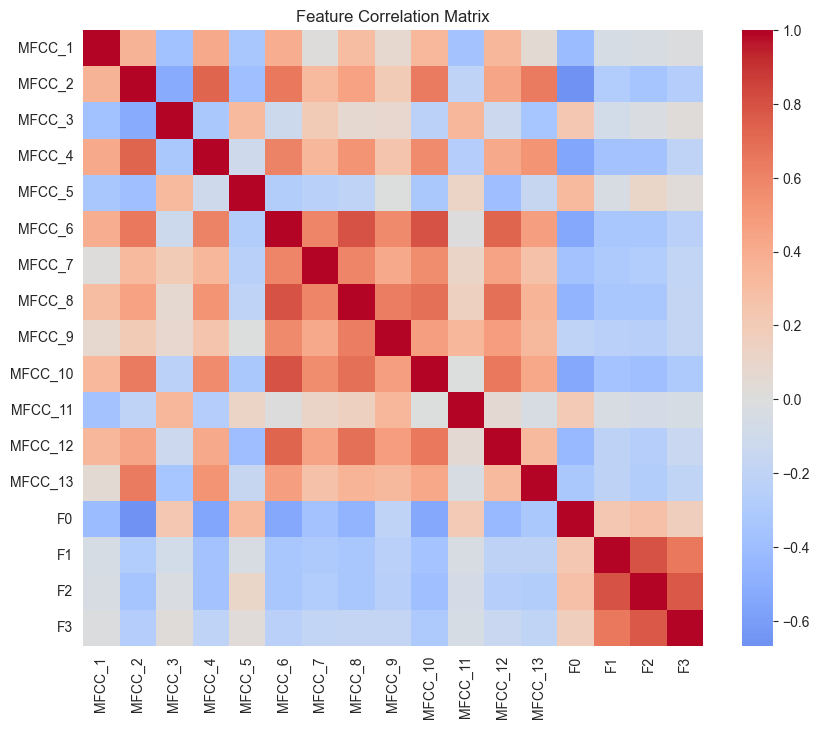

In [54]:
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=torgo_labels)
plt.xticks([0, 1], ['Control', 'Dysarthric'])
plt.title("Class Distribution (TORGO)")
plt.show()

# Sample Audio Visualization
if len(torgo_files) > 0:
    plot_waveform_spectrogram(torgo_files[0], title="Sample Audio (TORGO)")

# Feature Distributions
plot_feature_distributions(torgo_features, torgo_labels, feat_names)

### 4.2 Hypothesis Testing (TORGO)
We perform statistical tests to verify if there are significant differences between Control and Dysarthric speakers for key features.

In [55]:
# Hypothesis Test for Pitch (F0)
f0_idx = 13
perform_formal_hypothesis_testing(torgo_features, torgo_labels, feature_index=f0_idx, feature_name="Pitch (F0)")

# Hypothesis Test for First Formant (F1)
f1_idx = 14
perform_formal_hypothesis_testing(torgo_features, torgo_labels, feature_index=f1_idx, feature_name="First Formant (F1)")

--- Hypothesis Testing for Pitch (F0) ---
1. State the Hypotheses:
   Null Hypothesis (H0): There is no significant difference in the mean Pitch (F0) between Control and Dysarthric speakers.
   Alternative Hypothesis (H1): There is a significant difference in the mean Pitch (F0) between Control and Dysarthric speakers.

2. Set the Significance Level (α):
   α = 0.05

3. Collect Data:
   Control samples: 11454
   Dysarthric samples: 6145
   Mean (Control): 356.8321
   Mean (Dysarthric): 390.0936

4. Perform the Statistical Test:
   Test Statistic (t): -9.4068
   p-value: 5.9289e-21

5. Interpret the Results:
   Since p-value (5.9289e-21) < α (0.05), we REJECT the Null Hypothesis.
   Conclusion: There is statistically significant evidence to suggest a difference in Pitch (F0) between the two groups.
------------------------------------------------------------

--- Hypothesis Testing for First Formant (F1) ---
1. State the Hypotheses:
   Null Hypothesis (H0): There is no significant diffe

### 4.3 PCA and Modeling (TORGO)

Original feature count: 17
Reduced feature count: 13


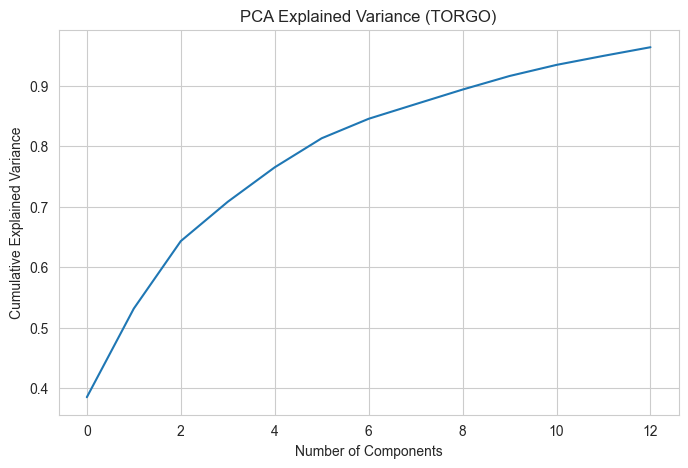

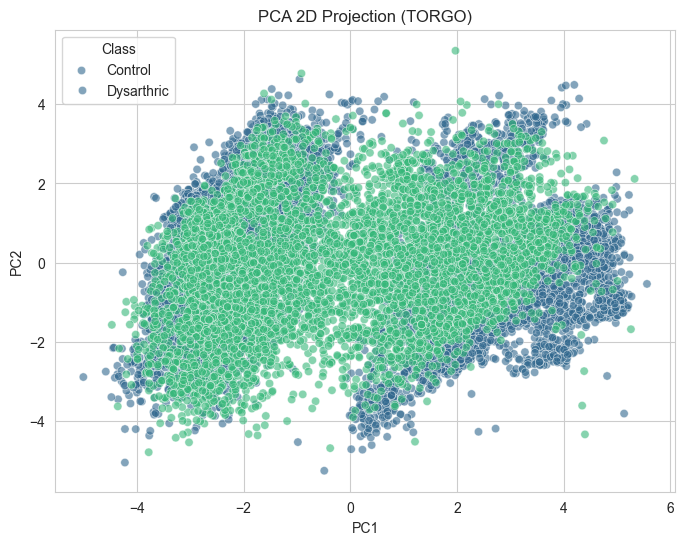

Random Forest Accuracy: 0.8818
Bayesian GMM Accuracy: 0.8417
HMM Accuracy: 0.6468


In [56]:
# Standardize features
scaler = StandardScaler()
torgo_features_scaled = scaler.fit_transform(torgo_features)

# Apply PCA
pca = PCA(n_components=0.95) # Keep 95% variance
torgo_features_pca = pca.fit_transform(torgo_features_scaled)

print(f"Original feature count: {torgo_features.shape[1]}")
print(f"Reduced feature count: {torgo_features_pca.shape[1]}")

# PCA Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance (TORGO)')
plt.grid(True)
plt.show()

# PCA 2D Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=torgo_features_pca[:, 0], y=torgo_features_pca[:, 1], hue=torgo_labels, palette='viridis', alpha=0.6)
plt.title('PCA 2D Projection (TORGO)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Class', labels=['Control', 'Dysarthric'])
plt.show()

# Split data
X_train, X_test, y_train, y_test = train_test_split(torgo_features_pca, torgo_labels, test_size=0.3, random_state=42)

# 1. Random Forest (Parallelized)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]
rf_acc = accuracy_score(y_test, rf_pred)

# 2. Bayesian GMM
bgm_0 = BayesianGaussianMixture(n_components=5, random_state=42)
bgm_1 = BayesianGaussianMixture(n_components=5, random_state=42)
bgm_0.fit(X_train[y_train == 0])
bgm_1.fit(X_train[y_train == 1])
bgm_pred = []
bgm_probs = []
for x in X_test:
    log_prob_0 = bgm_0.score(x.reshape(1, -1))
    log_prob_1 = bgm_1.score(x.reshape(1, -1))
    bgm_pred.append(0 if log_prob_0 > log_prob_1 else 1)
    # Simple prob approximation
    prob_1 = np.exp(log_prob_1) / (np.exp(log_prob_0) + np.exp(log_prob_1) + 1e-10)
    bgm_probs.append(prob_1)
bgm_acc = accuracy_score(y_test, bgm_pred)

# 3. HMM
hmm_0 = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
hmm_1 = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
hmm_0.fit(X_train[y_train == 0])
hmm_1.fit(X_train[y_train == 1])
hmm_pred = []
hmm_probs = []
for x in X_test:
    log_prob_0 = hmm_0.score(x.reshape(1, -1))
    log_prob_1 = hmm_1.score(x.reshape(1, -1))
    hmm_pred.append(0 if log_prob_0 > log_prob_1 else 1)
    prob_1 = np.exp(log_prob_1) / (np.exp(log_prob_0) + np.exp(log_prob_1) + 1e-10)
    hmm_probs.append(prob_1)
hmm_acc = accuracy_score(y_test, hmm_pred)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"Bayesian GMM Accuracy: {bgm_acc:.4f}")
print(f"HMM Accuracy: {hmm_acc:.4f}")

### 4.4 Model Evaluation Plots (TORGO)

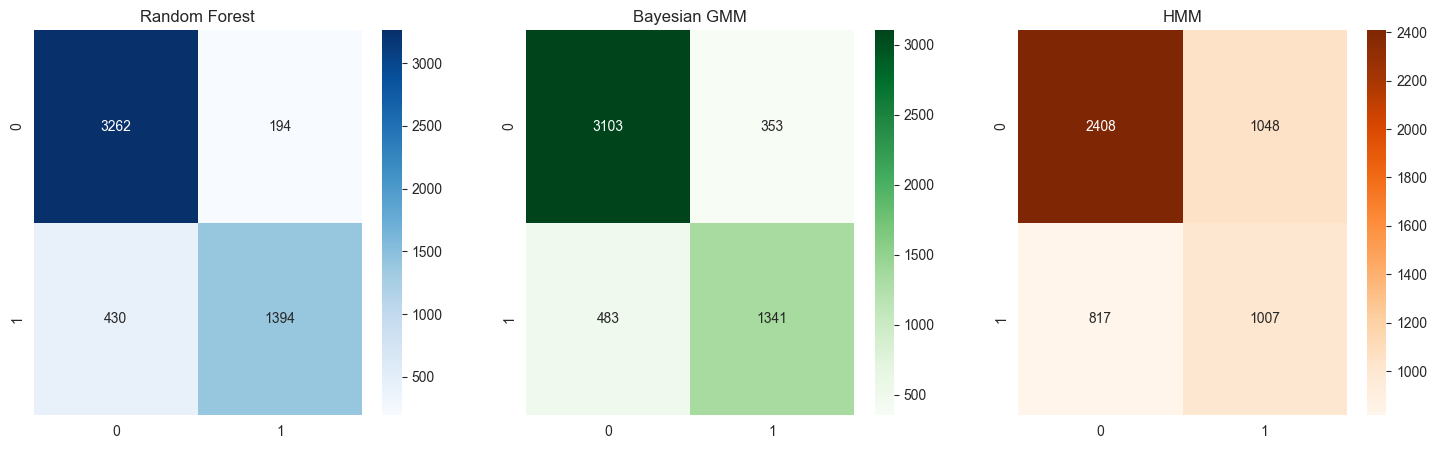

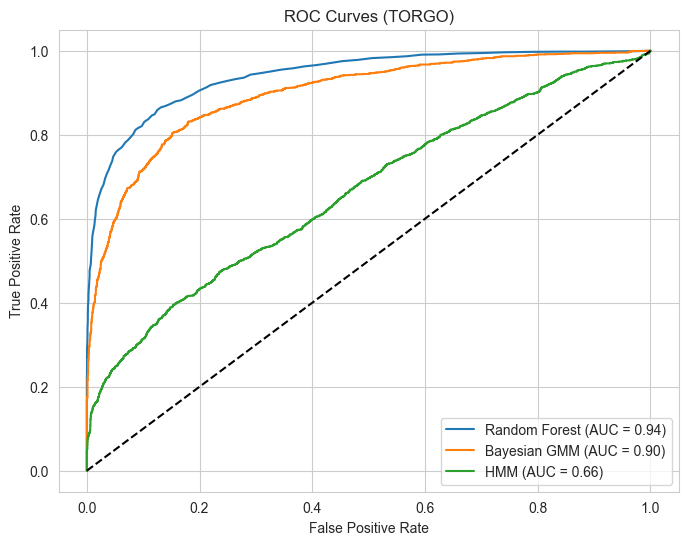

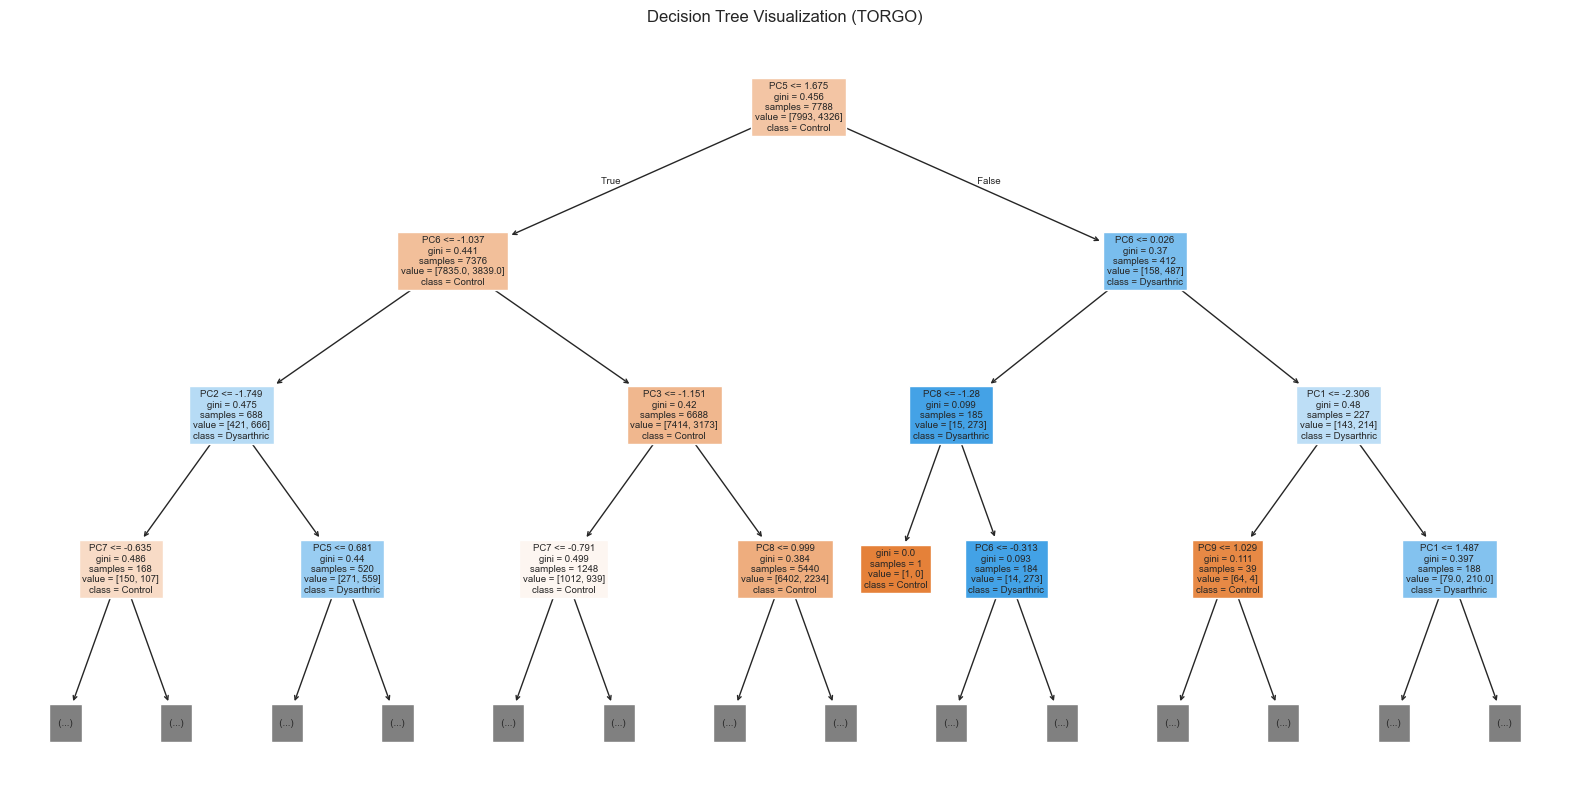

In [57]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Random Forest')
sns.heatmap(confusion_matrix(y_test, bgm_pred), annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('Bayesian GMM')
sns.heatmap(confusion_matrix(y_test, hmm_pred), annot=True, fmt='d', ax=axes[2], cmap='Oranges')
axes[2].set_title('HMM')
plt.show()

# ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_bgm, tpr_bgm, _ = roc_curve(y_test, bgm_probs)
fpr_hmm, tpr_hmm, _ = roc_curve(y_test, hmm_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})')
plt.plot(fpr_bgm, tpr_bgm, label=f'Bayesian GMM (AUC = {auc(fpr_bgm, tpr_bgm):.2f})')
plt.plot(fpr_hmm, tpr_hmm, label=f'HMM (AUC = {auc(fpr_hmm, tpr_hmm):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (TORGO)')
plt.legend()
plt.show()

# Decision Tree Visualization
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0], max_depth=3, filled=True, feature_names=[f'PC{i+1}' for i in range(X_train.shape[1])], class_names=['Control', 'Dysarthric'])
plt.title('Decision Tree Visualization (TORGO)')
plt.show()

## 5. RAWDysPeech Dataset Pipeline

In [58]:
RAW_PATH = r"C:\Users\91959\Documents\BTech Studies\7th Semester Studies\Pattern Recognition_PE_05\PR Project\RAWDysPeech dataset"

print("Processing RAWDysPeech dataset...")
raw_categories = {'0': 0, '1': 1}
raw_files, raw_labels_all = get_file_paths(RAW_PATH, raw_categories)

# Subsample (100% - Full Dataset)
if sample_rate < 1.0:
    indices = np.random.choice(len(raw_files), int(len(raw_files) * sample_rate), replace=False)
    raw_files = raw_files[indices]
    raw_labels_all = raw_labels_all[indices]

raw_features, valid_idx_raw = extract_features_parallel(raw_files)
raw_labels = raw_labels_all[valid_idx_raw]
print(f"RAWDysPeech features shape: {raw_features.shape}")

Processing RAWDysPeech dataset...
Extracting features from 160923 files using -1 jobs...
Finished in 1447.78 seconds.
RAWDysPeech features shape: (160889, 17)


### 5.1 Exploratory Data Analysis (RAWDysPeech)

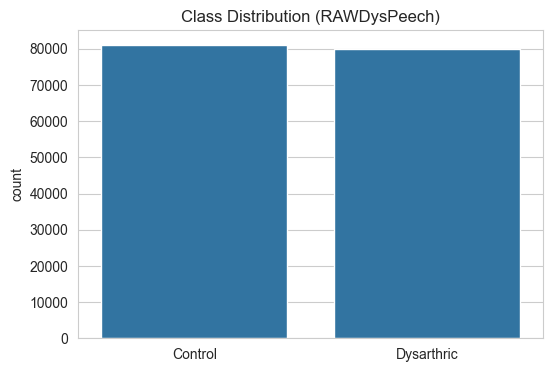

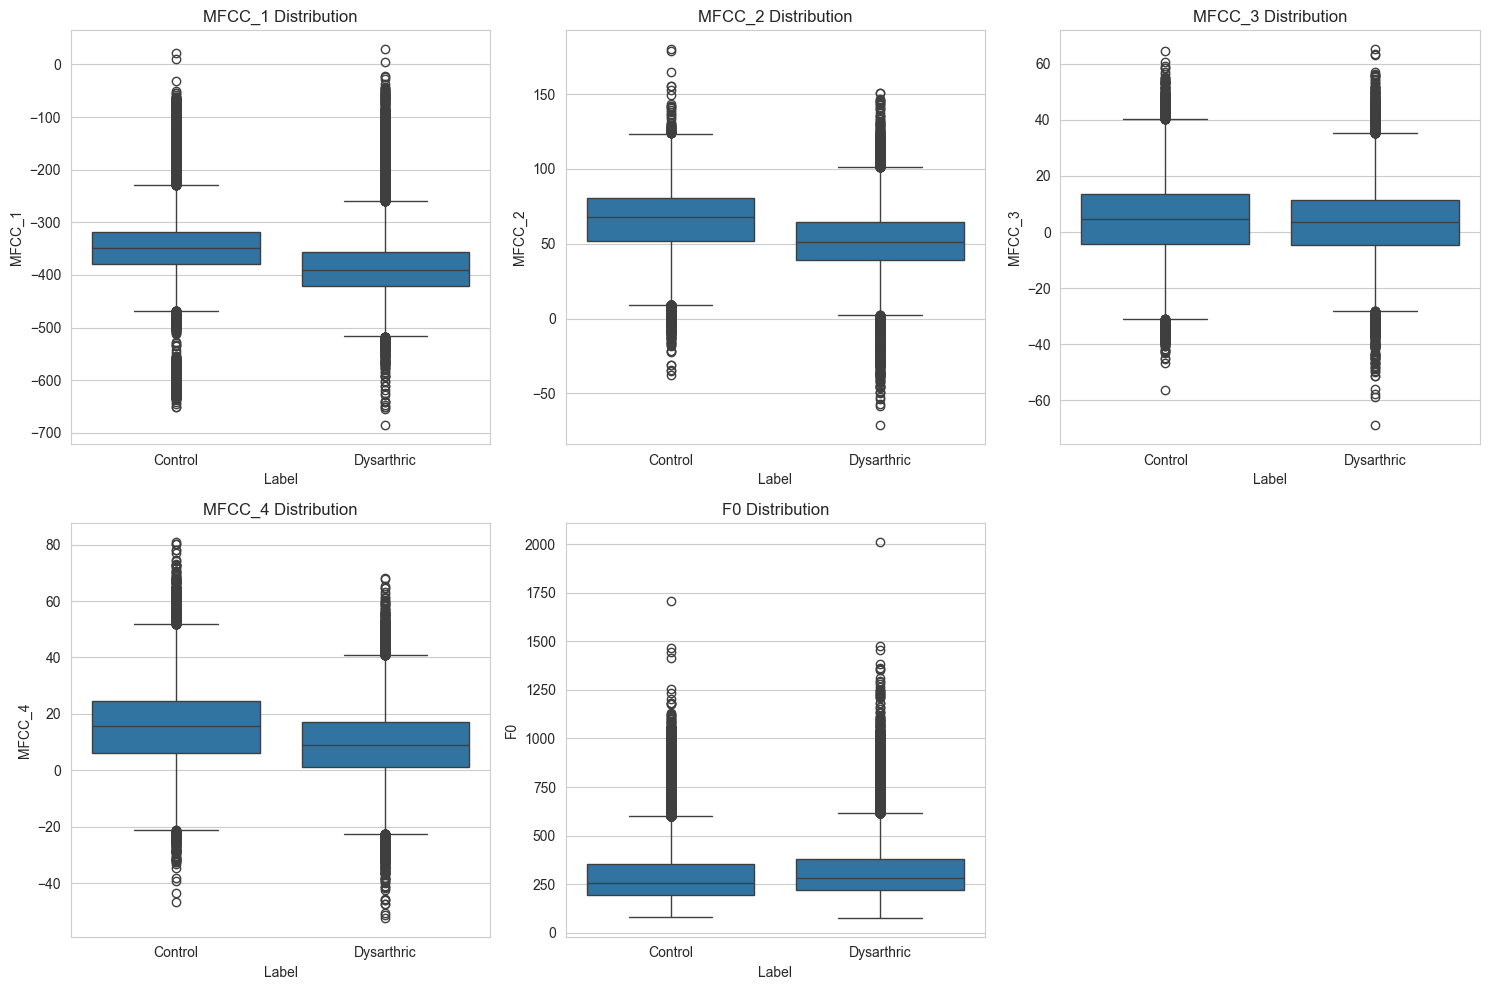

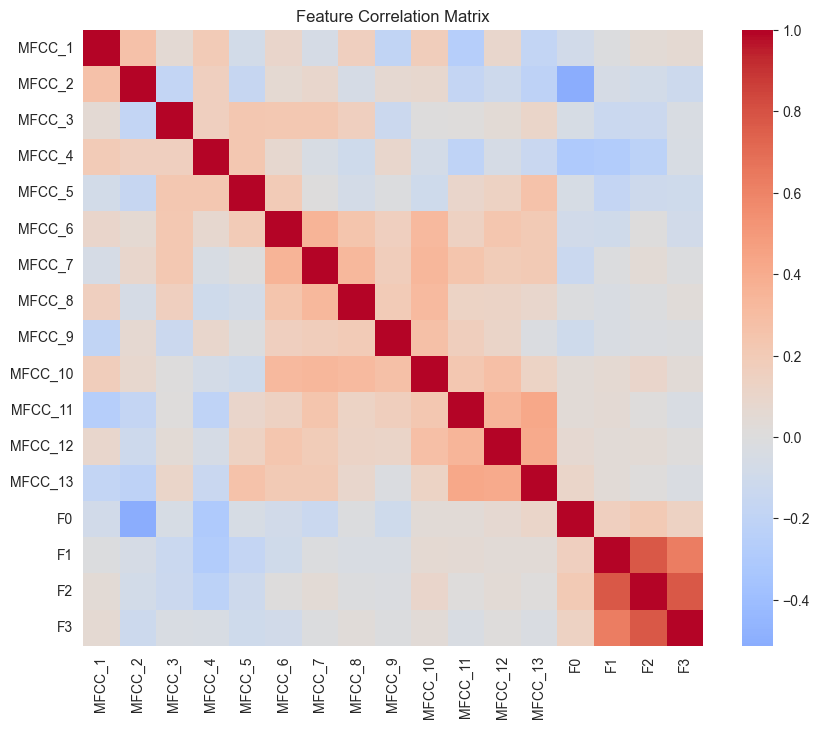

In [59]:
# Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=raw_labels)
plt.xticks([0, 1], ['Control', 'Dysarthric'])
plt.title("Class Distribution (RAWDysPeech)")
plt.show()

# Feature Distributions
plot_feature_distributions(raw_features, raw_labels, feat_names)

### 5.2 Hypothesis Testing (RAWDysPeech)

In [60]:
# Hypothesis Test for Pitch (F0)
perform_formal_hypothesis_testing(raw_features, raw_labels, feature_index=f0_idx, feature_name="Pitch (F0)")

# Hypothesis Test for First Formant (F1)
perform_formal_hypothesis_testing(raw_features, raw_labels, feature_index=f1_idx, feature_name="First Formant (F1)")

--- Hypothesis Testing for Pitch (F0) ---
1. State the Hypotheses:
   Null Hypothesis (H0): There is no significant difference in the mean Pitch (F0) between Control and Dysarthric speakers.
   Alternative Hypothesis (H1): There is a significant difference in the mean Pitch (F0) between Control and Dysarthric speakers.

2. Set the Significance Level (α):
   α = 0.05

3. Collect Data:
   Control samples: 81069
   Dysarthric samples: 79820
   Mean (Control): 294.1313
   Mean (Dysarthric): 314.9065

4. Perform the Statistical Test:
   Test Statistic (t): -30.5615
   p-value: 1.5417e-204

5. Interpret the Results:
   Since p-value (1.5417e-204) < α (0.05), we REJECT the Null Hypothesis.
   Conclusion: There is statistically significant evidence to suggest a difference in Pitch (F0) between the two groups.
------------------------------------------------------------

--- Hypothesis Testing for First Formant (F1) ---
1. State the Hypotheses:
   Null Hypothesis (H0): There is no significant d

### 5.3 PCA and Modeling (RAWDysPeech)

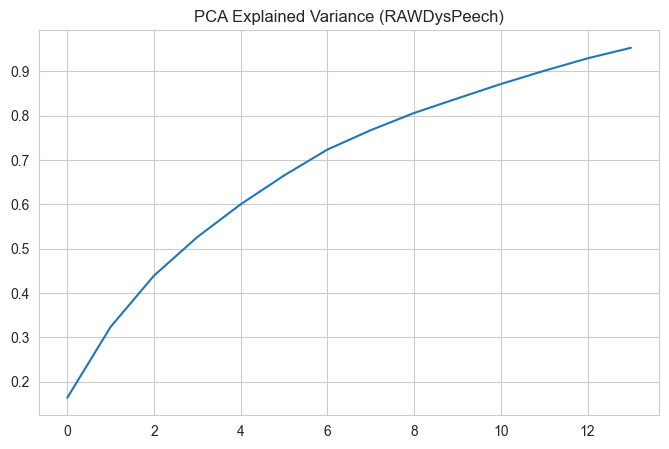

Random Forest Accuracy (RAW): 0.8781
Bayesian GMM Accuracy (RAW): 0.8317
HMM Accuracy (RAW): 0.6279


In [61]:
# Standardize
scaler_raw = StandardScaler()
raw_features_scaled = scaler_raw.fit_transform(raw_features)

# PCA
pca_raw = PCA(n_components=0.95)
raw_features_pca = pca_raw.fit_transform(raw_features_scaled)

# PCA Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_raw.explained_variance_ratio_))
plt.title('PCA Explained Variance (RAWDysPeech)')
plt.grid(True)
plt.show()

# Split data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(raw_features_pca, raw_labels, test_size=0.3, random_state=42)

# 1. Random Forest
rf_model_raw = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_raw.fit(X_train_raw, y_train_raw)
rf_pred_raw = rf_model_raw.predict(X_test_raw)
rf_probs_raw = rf_model_raw.predict_proba(X_test_raw)[:, 1]
rf_acc_raw = accuracy_score(y_test_raw, rf_pred_raw)

# 2. Bayesian GMM
bgm_0_raw = BayesianGaussianMixture(n_components=5, random_state=42)
bgm_1_raw = BayesianGaussianMixture(n_components=5, random_state=42)
bgm_0_raw.fit(X_train_raw[y_train_raw == 0])
bgm_1_raw.fit(X_train_raw[y_train_raw == 1])
bgm_pred_raw = []
bgm_probs_raw = []
for x in X_test_raw:
    log_prob_0 = bgm_0_raw.score(x.reshape(1, -1))
    log_prob_1 = bgm_1_raw.score(x.reshape(1, -1))
    bgm_pred_raw.append(0 if log_prob_0 > log_prob_1 else 1)
    prob_1 = np.exp(log_prob_1) / (np.exp(log_prob_0) + np.exp(log_prob_1) + 1e-10)
    bgm_probs_raw.append(prob_1)
bgm_acc_raw = accuracy_score(y_test_raw, bgm_pred_raw)

# 3. HMM
hmm_0_raw = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
hmm_1_raw = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
hmm_0_raw.fit(X_train_raw[y_train_raw == 0])
hmm_1_raw.fit(X_train_raw[y_train_raw == 1])
hmm_pred_raw = []
hmm_probs_raw = []
for x in X_test_raw:
    log_prob_0 = hmm_0_raw.score(x.reshape(1, -1))
    log_prob_1 = hmm_1_raw.score(x.reshape(1, -1))
    hmm_pred_raw.append(0 if log_prob_0 > log_prob_1 else 1)
    prob_1 = np.exp(log_prob_1) / (np.exp(log_prob_0) + np.exp(log_prob_1) + 1e-10)
    hmm_probs_raw.append(prob_1)
hmm_acc_raw = accuracy_score(y_test_raw, hmm_pred_raw)

print(f"Random Forest Accuracy (RAW): {rf_acc_raw:.4f}")
print(f"Bayesian GMM Accuracy (RAW): {bgm_acc_raw:.4f}")
print(f"HMM Accuracy (RAW): {hmm_acc_raw:.4f}")

### 5.4 Model Evaluation Plots (RAWDysPeech)

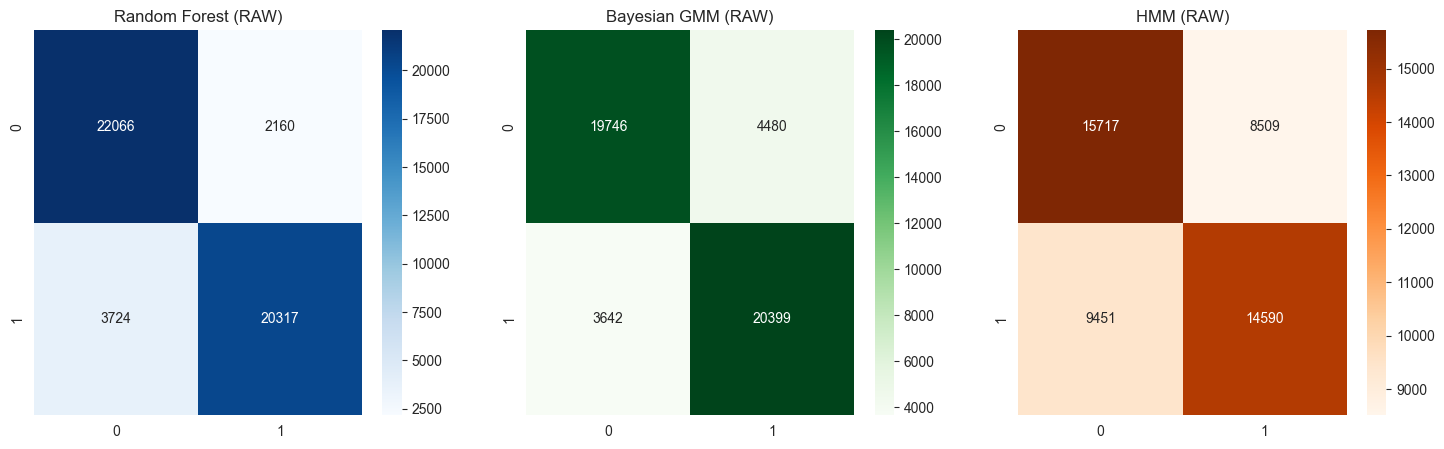

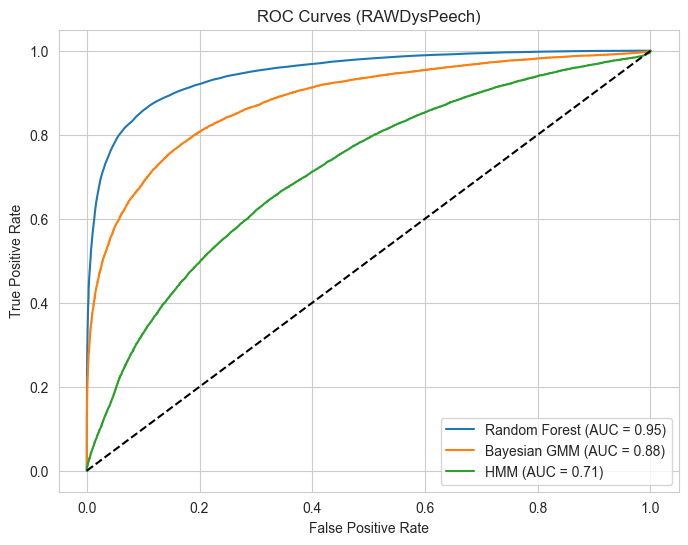

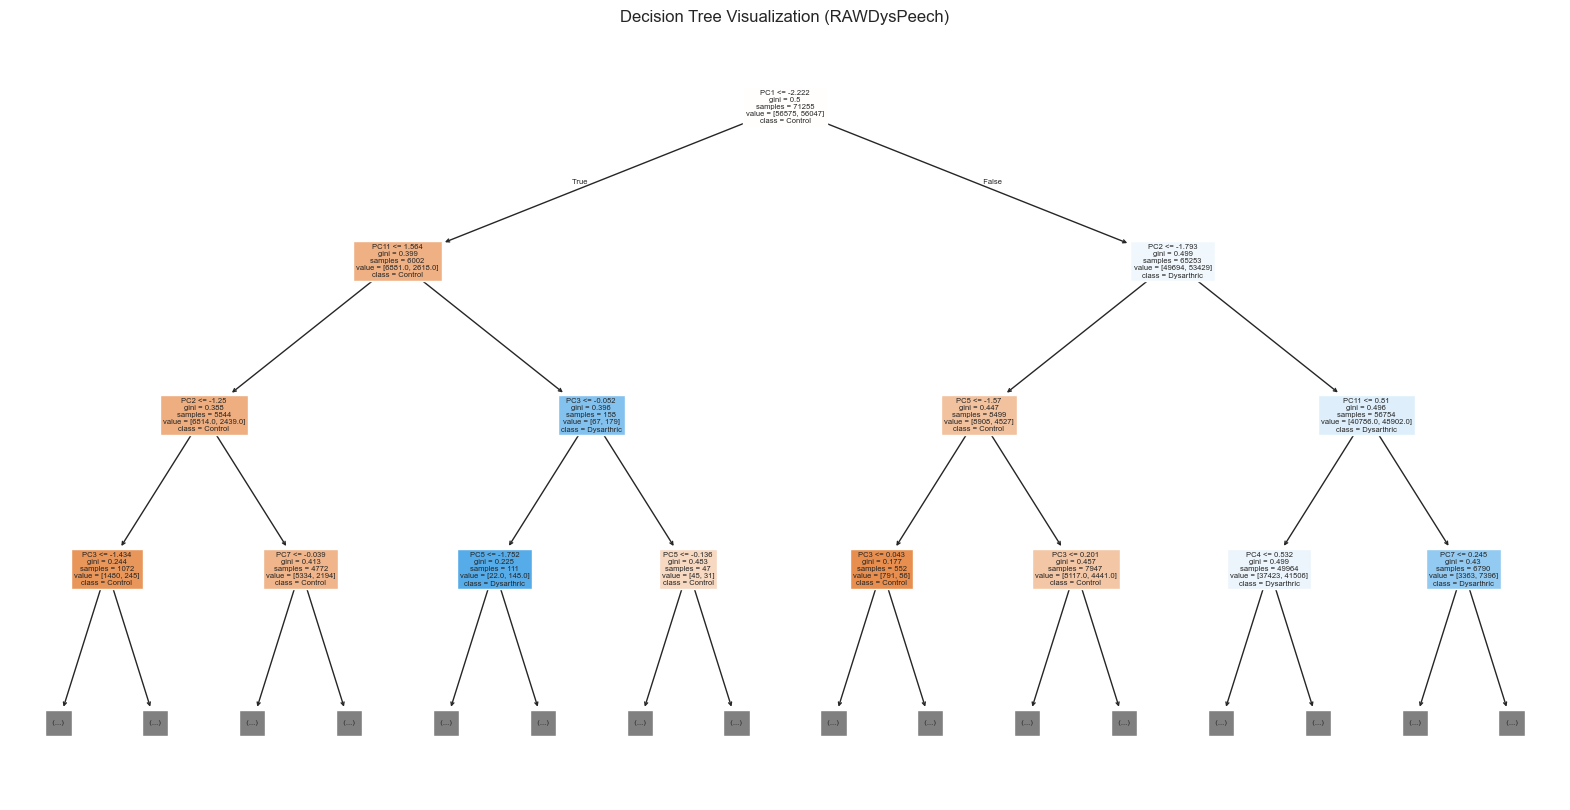

In [62]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(confusion_matrix(y_test_raw, rf_pred_raw), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Random Forest (RAW)')
sns.heatmap(confusion_matrix(y_test_raw, bgm_pred_raw), annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('Bayesian GMM (RAW)')
sns.heatmap(confusion_matrix(y_test_raw, hmm_pred_raw), annot=True, fmt='d', ax=axes[2], cmap='Oranges')
axes[2].set_title('HMM (RAW)')
plt.show()

# ROC Curves
fpr_rf_raw, tpr_rf_raw, _ = roc_curve(y_test_raw, rf_probs_raw)
fpr_bgm_raw, tpr_bgm_raw, _ = roc_curve(y_test_raw, bgm_probs_raw)
fpr_hmm_raw, tpr_hmm_raw, _ = roc_curve(y_test_raw, hmm_probs_raw)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_raw, tpr_rf_raw, label=f'Random Forest (AUC = {auc(fpr_rf_raw, tpr_rf_raw):.2f})')
plt.plot(fpr_bgm_raw, tpr_bgm_raw, label=f'Bayesian GMM (AUC = {auc(fpr_bgm_raw, tpr_bgm_raw):.2f})')
plt.plot(fpr_hmm_raw, tpr_hmm_raw, label=f'HMM (AUC = {auc(fpr_hmm_raw, tpr_hmm_raw):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (RAWDysPeech)')
plt.legend()
plt.show()

# Decision Tree Visualization
plt.figure(figsize=(20, 10))
plot_tree(rf_model_raw.estimators_[0], max_depth=3, filled=True, feature_names=[f'PC{i+1}' for i in range(X_train_raw.shape[1])], class_names=['Control', 'Dysarthric'])
plt.title('Decision Tree Visualization (RAWDysPeech)')
plt.show()

## 6. Comparison

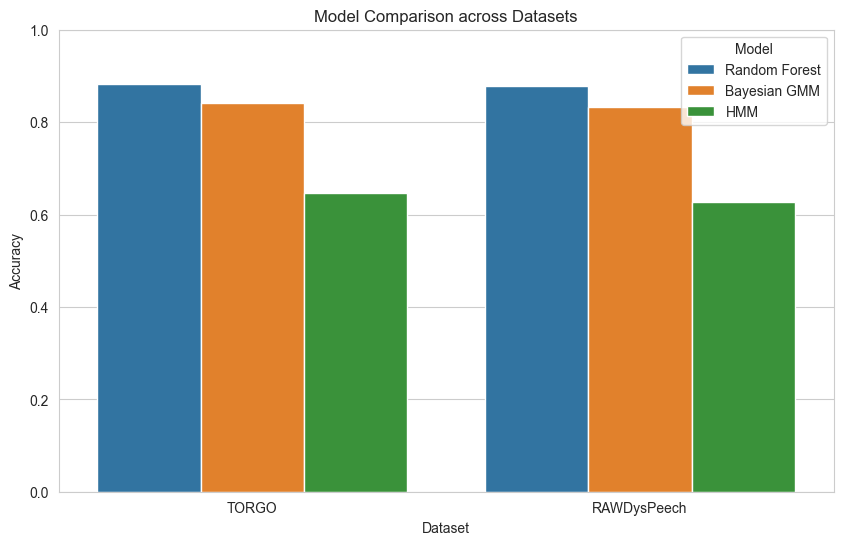

       Dataset          Model  Accuracy
0        TORGO  Random Forest  0.881818
1        TORGO   Bayesian GMM  0.841667
2        TORGO            HMM  0.646780
3  RAWDysPeech  Random Forest  0.878095
4  RAWDysPeech   Bayesian GMM  0.831728
5  RAWDysPeech            HMM  0.627903


In [63]:
results = {
    'Dataset': ['TORGO', 'TORGO', 'TORGO', 'RAWDysPeech', 'RAWDysPeech', 'RAWDysPeech'],
    'Model': ['Random Forest', 'Bayesian GMM', 'HMM', 'Random Forest', 'Bayesian GMM', 'HMM'],
    'Accuracy': [rf_acc, bgm_acc, hmm_acc, rf_acc_raw, bgm_acc_raw, hmm_acc_raw]
}

df_results = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x='Dataset', y='Accuracy', hue='Model')
plt.title('Model Comparison across Datasets')
plt.ylim(0, 1)
plt.show()

print(df_results)